![Clase aprendizaje no supervisado](https://raw.githubusercontent.com/MECA4605-Aprendizaje-no-supervisado/taller_2/main/figs/taller-meca-aprendizaje%20no%20supervisado_banner%201169%20x%20200%20px%20-05.png)

# Caso-taller:  Segmentación de Clientes con Clustering Jerárquico y DBSCAN

El objetivo de este caso-taller es analizar una base de datos ficticia sobre clientes de una tienda y buscar encontrar grupos de clientes que permitan generar estrategias de marketing focalizadas. La base se encuentra en los `Archivos de Laboratorio` en la carpeta `data` y cuenta con 200 observaciones y 5 variables:

- `Id_Cliente`: identificador de cliente.
- `Genero`: género del cliente: Mujer, Hombre
- `Edad`: edad en años
- `Ingreso`: ingresos anuales
- `Puntaje_Gasto`: es una variable que mide cuán a menudo un cliente compra en la tienda, siendo 100 el puntaje más alto.


## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1.Carga de datos

En la carpeta `data` se encuentra el archivo `datos_clientes.csv` cargue estos datos en su *cuaderno*.

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [51]:
df = pd.read_csv('https://raw.githubusercontent.com/MECA4605-Aprendizaje-no-supervisado/taller_2/refs/heads/main/data/datos_clientes.csv')
df.head()

,Id_Cliente,Genero,Edad,Ingreso,Puntaje_Gasto
0,1,Mujer,41,98115.05,39
1,2,Mujer,20,35458.14,75
2,3,Mujer,68,59872.08,55
3,4,Hombre,63,48508.93,51
4,5,Mujer,31,44431.11,54


Se cargan los datos del csv por medio de la URL de Github, adicionalmente, se cargan dentro de un dataframe

### 2. Análisis preliminar.

Antes de comenzar el análisis de segmentación utilice estadísticas descriptivas para explorar la variables que se encuentran en los datos. En su análisis mencione si hay patrones que surgen del examen descriptivo de los datos; entre ellos si hay diferencias en los ingresos y los puntajes de gastos para mujeres y hombres, por grupos etarios (18-24, 25-34, 35-44, 45-54, 55-64, y 65+), y por grupos etarios y género. Discuta además si estas diferencias son estadísticamente significativas.

In [52]:
# Definir la función de clasificación de edades por grupos etarios
def clasificar_edad(edad):
    if edad <= 24:
        return "18-24"
    elif edad > 24 and edad <= 34:
        return "25-34"
    elif edad > 34 and edad <= 44:
        return "35-44"
    elif edad > 44 and edad <= 54:
        return "45-54"
    elif edad > 54 and edad <= 64:
        return "55-64"
    else:
        return "65+"

# Crear la nueva columna categórica para grupos etarios
df['GruposEtarios'] = df['Edad'].apply(clasificar_edad)
df = df.drop('Edad', axis = 1)

#### Estadisticas descriptivas por grupos

##### Por Genero

In [53]:
# Agrupar por la variable categórica y calcular estadísticas descriptivas
estadisticas_por_categoria = df.groupby('Genero').describe()

# Mostrar las estadísticas descriptivas por categoría
round(estadisticas_por_categoria[['Ingreso']],2)

Ingreso                                                              \
         count      mean       std       min       25%       50%       75%   
Genero                                                                       
Hombre    88.0  62126.66  26765.49  13458.02  45003.08  61706.56  77731.30   
Mujer    112.0  59444.14  25920.46  15766.84  40013.41  59355.30  76788.39   

                   
              max  
Genero             
Hombre  138584.52  
Mujer   126685.78

In [54]:
# Mostrar las estadísticas descriptivas por categoría
round(estadisticas_por_categoria[['Puntaje_Gasto']],2)

Puntaje_Gasto                                           
               count   mean    std  min   25%   50%   75%   max
Genero                                                         
Hombre          88.0  48.51  27.90  1.0  24.5  50.0  70.0  97.0
Mujer          112.0  51.53  24.11  5.0  35.0  50.0  73.0  99.0

Como podemos apreciar, en promedio, las mujeres tienen un menor ingreso que los hombres, mientras que son los hombres los que en promedio gastan menos que las mujeres. Es importante destacar que las diferencias de los promedios realmente no están muy alejadas para ambos grupos; por otro lado, es de señalar que la muestra está desbalanceada siendo mujeres la mayoría de individuos, por lo que pueden presentarse sesgos en los datos.

Para ambos grupos, los percentiles 25 y 75 parecen ser simétricos para ingresos, caso diferente del Puntaje de Gasto.

#### Por Grupos Etarios

In [55]:
# Agrupar por la variable categórica y calcular estadísticas descriptivas
estadisticas_por_categoria = df.groupby('GruposEtarios').describe()

# Mostrar las estadísticas descriptivas por categoría
round(estadisticas_por_categoria[['Ingreso']],2)


Ingreso                                                    \
                count      mean       std       min       25%       50%   
GruposEtarios                                                             
18-24            35.0  44454.80  20378.21  13458.02  24465.32  46455.34   
25-34            54.0  71157.33  27885.79  19003.52  50141.66  75824.91   
35-44            42.0  66957.10  27722.05  18797.16  50771.22  71638.86   
45-54            39.0  58786.49  24276.27  24402.32  42447.56  55041.39   
55-64            16.0  56357.09  22351.83  18434.74  46947.21  54718.18   
65+              14.0  51420.79  12686.44  18437.21  45659.18  51546.64   

                                    
                    75%        max  
GruposEtarios                       
18-24          61564.36   80360.65  
25-34          85872.94  138584.52  
35-44          86762.78  119534.68  
45-54          67337.10  126685.78  
55-64          72384.28   94049.49  
65+            61858.47   64156.37

In [56]:
round(estadisticas_por_categoria[['Puntaje_Gasto']],2)

Puntaje_Gasto                                              
                      count   mean    std   min    25%   50%    75%   max
GruposEtarios                                                            
18-24                  35.0  56.26  24.66   5.0  44.00  55.0  76.50  94.0
25-34                  54.0  63.17  24.28   1.0  47.75  70.0  82.75  97.0
35-44                  42.0  49.43  30.70   1.0  21.50  41.0  75.75  99.0
45-54                  39.0  36.23  16.26   4.0  25.00  42.0  47.50  59.0
55-64                  16.0  32.31  21.75   3.0  13.25  39.0  51.00  60.0
65+                    14.0  46.71  11.43  14.0  43.75  49.0  54.25  59.0

Como podemos apreciar, son los individuos entre 25-34 años los que en promedio tienen mayores ingresos y Puntaje de Gasto; por otro lado, los individuos entre 18-24 son los que perciben menores ingresos en promedio, mientras los que menos Puntaje de Gasto tienen son los individuos entre 55-64. Una vez mas la muestra está desbalanceada, siendo la mayoría de individuos los que tienen entre 35-44 años, mientras que la minoría son los mayores a 65.

##### Por Genero y Grupo Etario

In [ ]:
# Agrupar por las variables categóricas "Grupo Etario" y "Genero", luego calcular estadísticas descriptivas
estadisticas_por_categoria = df.groupby(['GruposEtarios', 'Genero']).describe()

# Mostrar las estadísticas descriptivas por categorías
round(estadisticas_por_categoria[['Ingreso']],2)

Ingreso                                          \
                       count      mean       std       min       25%   
GruposEtarios Genero                                                   
18-24         Hombre    16.0  46748.48  21515.09  13458.02  29984.65   
              Mujer     19.0  42523.27  19749.37  15766.84  23830.82   
25-34         Hombre    22.0  78927.43  32734.45  22531.85  61793.42   
              Mujer     32.0  65815.38  23049.65  19003.52  46428.23   
35-44         Hombre    18.0  67001.99  22499.53  18797.16  58063.71   
              Mujer     24.0  66923.43  31556.05  19281.75  37553.35   
45-54         Hombre    14.0  58029.13  20522.77  24993.78  43724.24   
              Mujer     25.0  59210.61  26541.55  24402.32  41739.84   
55-64         Hombre     9.0  55780.23  25094.51  18434.74  42262.04   
              Mujer      7.0  57098.78  20204.55  19617.67  49946.06   
65+           Hombre     9.0  51366.81  14577.26  18437.21  45222.06   
              Mujer      5.0  51517.96   9902.63  37926.15  46970.54   

                                                     
                           50%       75%        max  
GruposEtarios Genero                                 
18-24         Hombre  47652.49  60447.45   80360.65  
              Mujer   38599.28  61699.16   71427.64  
25-34         Hombre  77390.98  96065.52  138584.52  
              Mujer   72515.76  78621.06  103654.79  
35-44         Hombre  71638.86  83590.71   91426.18  
              Mujer   72184.82  89797.32  119534.68  
45-54         Hombre  60761.56  69593.59   97525.80  
              Mujer   54827.74  67219.48  126685.78  
55-64         Hombre  54475.76  71651.08   94049.49  
              Mujer   58838.53  70389.06   80565.01  
65+           Hombre  52200.84  61969.15   64156.37  
              Mujer   50529.76  59872.08   62291.26

In [ ]:
# Mostrar las estadísticas descriptivas por categorías
round(estadisticas_por_categoria[['Puntaje_Gasto']],2)

Puntaje_Gasto                                          \
                             count   mean    std   min    25%   50%    75%   
GruposEtarios Genero                                                         
18-24         Hombre          16.0  51.88  27.80   5.0  40.50  53.5  69.25   
              Mujer           19.0  59.95  21.75   6.0  49.00  57.0  76.50   
25-34         Hombre          22.0  62.45  28.47   1.0  55.25  71.0  80.25   
              Mujer           32.0  63.66  21.41  22.0  45.75  70.0  83.75   
35-44         Hombre          18.0  50.78  33.50   1.0  17.75  51.5  84.75   
              Mujer           24.0  48.42  29.12   6.0  26.75  40.0  75.25   
45-54         Hombre          14.0  34.36  15.78   4.0  26.75  38.5  46.00   
              Mujer           25.0  37.28  16.75   5.0  24.00  43.0  50.00   
55-64         Hombre           9.0  28.44  23.17   3.0  11.00  15.0  51.00   
              Mujer            7.0  37.29  20.39   5.0  25.00  43.0  52.50   
65+           Hombre           9.0  46.00  13.45  14.0  43.00  48.0  55.00   
              Mujer            5.0  48.00   7.71  35.0  48.00  50.0  52.00   

                            
                       max  
GruposEtarios Genero        
18-24         Hombre  92.0  
              Mujer   94.0  
25-34         Hombre  97.0  
              Mujer   95.0  
35-44         Hombre  95.0  
              Mujer   99.0  
45-54         Hombre  56.0  
              Mujer   59.0  
55-64         Hombre  60.0  
              Mujer   58.0  
65+           Hombre  59.0  
              Mujer   55.0

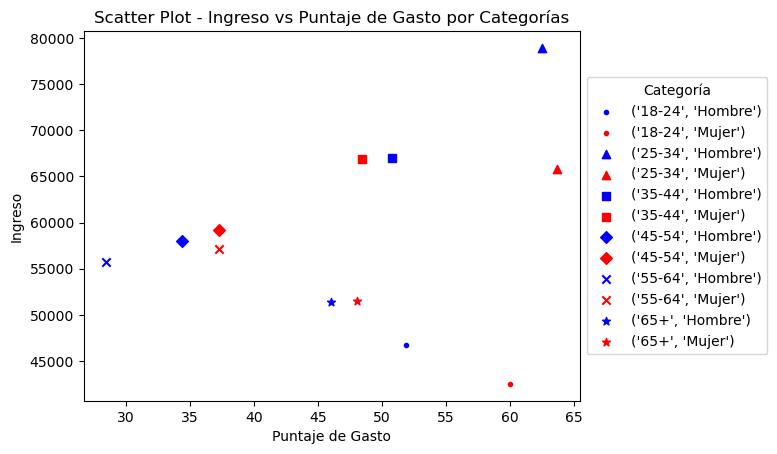

In [71]:
# Crearemos un Scatterplot de las medias de los ingresos vs medias de los Puntajes de Gasto para cada Genero y Grupo Etario.

# Crear el scatter plot
fig, ax = plt.subplots()

# Usar un bucle para graficar cada categoría con un color diferente
categorias = estadisticas_por_categoria.index.unique()
marcadores = ['.', '.', '^', '^', 's', 's', 'D', 'D', 'x', 'x', '*', '*']
Colores = ['blue', 'red','blue', 'red','blue', 'red','blue', 'red','blue', 'red','blue', 'red']

marcont = 0

for categoria in categorias:
    subset = estadisticas_por_categoria[estadisticas_por_categoria.index == categoria]
    ax.scatter(subset['Puntaje_Gasto']['mean'], subset['Ingreso']['mean'], label=categoria, marker=marcadores[marcont], color=Colores[marcont])
    marcont = marcont + 1

# Añadir leyenda y etiquetas
ax.legend(title='Categoría', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Puntaje de Gasto')
ax.set_ylabel('Ingreso')
ax.set_title('Scatter Plot - Ingreso vs Puntaje de Gasto por Categorías')

# Mostrar el gráfico
plt.show()

Como se aprecia en las estadisticas y gráficos, los ingresos promedio tanto para hombres como para mujeres parece estar muy parejo por Grupo Etario salvo para las edades entre 35-34 años; en cuanto al puntaje de gasto, en la mayoría de Grupos Etarios, las mujeres tienen mayor puntaje de gasto que los hombres, este comportamiento es más pronunciados en los grupos etarios de 65+ y 18-24, solo en el grupo de 35-44 los hombres tienen en promedio mayor Puntaje de gasto que las mujeres.

##### Significancia estadística

Procedemos a hacer la regresión lineal discriminando los individuos por Grupo Etario y Genero.

In [128]:
#Creamos el dataframe con las variables dummy categoricas y sus respectivas combinaciones
dfreg = df
dfreg = dfreg.drop('Id_Cliente', axis = 1)
dfreg = pd.get_dummies(dfreg, 'GruposEtarios', drop_first= True)
dfreg = pd.get_dummies(dfreg, 'Genero', drop_first= True)
dfreg = dfreg.astype(int)
dfreg['Mujer_25-34'] = dfreg['GruposEtarios_Mujer'] * dfreg['GruposEtarios_25-34']
dfreg['Mujer_35-44'] = dfreg['GruposEtarios_Mujer'] * dfreg['GruposEtarios_35-44']
dfreg['Mujer_45-54'] = dfreg['GruposEtarios_Mujer'] * dfreg['GruposEtarios_45-54']
dfreg['Mujer_55-64'] = dfreg['GruposEtarios_Mujer'] * dfreg['GruposEtarios_55-64']
dfreg['Mujer_65+'] = dfreg['GruposEtarios_Mujer'] * dfreg['GruposEtarios_65+']
dfreg['Intercepto'] = 1
dfreg

,Ingreso,Puntaje_Gasto,GruposEtarios_Mujer,GruposEtarios_25-34,GruposEtarios_35-44,GruposEtarios_45-54,GruposEtarios_55-64,GruposEtarios_65+,Mujer_25-34,Mujer_35-44,Mujer_45-54,Mujer_55-64,Mujer_65+,Intercepto
0,98115,39,1,0,1,0,0,0,0,1,0,0,0,1
1,35458,75,1,0,0,0,0,0,0,0,0,0,0,1
2,59872,55,1,0,0,0,0,1,0,0,0,0,1,1
3,48508,51,0,0,0,0,1,0,0,0,0,0,0,1
4,44431,54,1,1,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,19322,72,1,1,0,0,0,0,1,0,0,0,0,1
196,43486,45,1,0,0,1,0,0,0,0,1,0,0,1
197,24086,35,0,0,1,0,0,0,0,0,0,0,0,1
198,38599,65,1,0,0,0,0,0,0,0,0,0,0,1


In [136]:
X = dfreg[['GruposEtarios_Mujer',
       'GruposEtarios_25-34', 'GruposEtarios_35-44', 'GruposEtarios_45-54',
       'GruposEtarios_55-64', 'GruposEtarios_65+', 'Mujer_25-34',
       'Mujer_35-44', 'Mujer_45-54', 'Mujer_55-64', 'Mujer_65+', 'Intercepto']]

Y = dfreg[['Ingreso']]

In [139]:
modelo = sm.OLS(Y, X).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                Ingreso   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     3.061
Date:              sáb., 26 abr. 2025   Prob (F-statistic):           0.000851
Time:                        19:38:40   Log-Likelihood:                -2302.0
No. Observations:                 200   AIC:                             4628.
Df Residuals:                     188   BIC:                             4668.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
GruposEtarios_Mujer -4225.0230   8

Como podemos apreciar en los resultados de la regresión de ingresos, solo las variables Intercepto (Dummy Mujer=0 y 18-24= 0; es decir Hombre de 18-25), GruposEtarios_25-34 (Dummy Mujer=0 y 18-24= 0; es decir Hombre de 25-34) y GruposEtarios_35-44 (Dummy Mujer=0 y 18-24= 0; es decir Hombre de 35-44) son estadisticamente significativas al 5%, por lo menos para el modelo líneal.

In [140]:
Y = dfreg[['Puntaje_Gasto']]
modelo = sm.OLS(Y, X).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:          Puntaje_Gasto   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     3.836
Date:              sáb., 26 abr. 2025   Prob (F-statistic):           5.37e-05
Time:                        19:48:27   Log-Likelihood:                -913.29
No. Observations:                 200   AIC:                             1851.
Df Residuals:                     188   BIC:                             1890.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
GruposEtarios_Mujer     8.0724    

Como podemos apreciar en los resultados de la regresión de Puntaje de Gasto, solo las variables Intercepto (Dummy Mujer=0 y 18-24= 0; es decir Hombre de 18-25) y GruposEtarios_55-64 (Dummy Mujer=0 y 55-64= 0; es decir Hombre de 25-34) son estadisticamente significativas al 5%, por lo menos para el modelo líneal.

La conclusión final es que, según las estadisticas descriptivas, gráficas y regresiones, no todos los grupos tienes variaciones discriminatorios importantes en ingreso o en Puntaje de Gasto.

### 3. Clustering Jerárquico

#### 3.1. Dendrogramas

Agrupe a los clientes utilizando sólo dos variables: su ingreso y el puntaje de gastos. Para ello retenga estas dos variables, estandarízelas, construya y grafique un dendograma. Para la construcción del dendrograma utilice el enlace 'ward' y la distancia euclidiana. Explique la importnacia de estandarizar los datos.

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir su procedimiento)

#### 3.2. Número de clusters

Retenga el número de clusters que se obtengan luego de fijar la distancia en 6.

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir su procedimiento)

#### 3.3. Algoritmo Jerárquico Aglomerativo

Utilizando el número de clusters encontrados en el paso anterior, aplique el algoritmo jerárquico aglomerativo, utilizando el enlace 'ward' y la distancia euclidiana. Describa los grupos encontrados, en que grupo o grupos concentraría su estrategia de marketing y por qué?

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir su procedimiento)

### 4. DBSCAN

Implemente DBSCAN, al igual que el punto anterior sólo dos variables: su ingreso y el puntaje de gastos. Al implementar  justifique su elección de `min_samples` y `eps`. ¿Cuántos grupos o clusters encuentra? ¿Cuáles son su características? ¿Cambiaría su estrategia de marketing respecto al punto anterior? Justifique su respuesta.

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir su procedimiento)

### 5. Incorporando más dimensiones

Hasta este momento hemos utilizado solo dos variables para nuestro análisis, sin embargo, la base cuenta con otras variables más: género y edad. Usando las categorías de edad creadas anteriormente incorpore género y grupo etario a su análisis. Genere los grupos utilizando DBSCAN y la distancia de Gower, justificando su elección de `min_samples` y `eps`   ¿Incorporar estas variables, ayuda a la focalización de la estrategia de marketing?

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir su procedimiento)